## 1. Efficient Net download
Install efficientnet downloaded from github. If using Kaggle, please switch on internet.

In [1]:
# output is hidden in view version
!pip3 install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-a7hgffw1
     |████████████████████████████████| 50 kB 832 kB/s eta 0:00:011
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18420 sha256=1662b22aff40f162ccc4da870169fa0739bd4741cfe49ea4091950b4ab1ec19e
  Stored in directory: /tmp/pip-ephem-wheel-cache-0arpqv6a/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 2. Import packages
<span style = "color:red"> Could we remove the imports that aren't being used? </span>

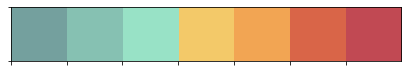

In [2]:
# Regular Imports
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import seaborn as sns
import math
import cv2
import pydicom
import os
import glob
import pickle as pkl
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
from skimage.transform import resize
import copy
import re
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Segmentation
import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

# Model imports
import tensorflow as tf 
from tensorflow.keras.layers import (
                                    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D,
                                    Add, Conv2D, AveragePooling2D, LeakyReLU, Concatenate , Lambda
                                    )
from tensorflow.keras import Model
import tensorflow.keras.models as M
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
# import tensorflow.keras.applications as tfa
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns


pd.set_option("display.max_columns", 100)
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.palplot(sns.color_palette(custom_colors))

## 3. Tuned Hyperparameters
We define the number of -
* **epochs** : the number of times we loop through the dataset. 
* **batch_size**: how many training examples to feed into network before updating the weights and internal nodes
* **LR**: learning rate
* **MODEL_CLASS**:  allow us to define which efficientnet model we want to use
* **SAVE_BEST**: defined as true, to only save the model due to 'early stopping' implemented

In [3]:
EPOCHS = 40
BATCH_SIZE = 8
NFOLD = 5
LR = 0.003
SAVE_BEST = True
MODEL_CLASS = 'b1'
path = '../input/osic-pulmonary-fibrosis-progression'

## 4. Train-Test split
We create a test dataset with 20% of unique patients and their associated data; 80% for training. 
Duplicates are dropped as some patients have more than one recorded FVC value for each week. 

In [4]:
all_data = pd.read_csv(f'{path}/train.csv') 
all_data.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
unique_patients = all_data.Patient.unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)
train = all_data[all_data['Patient'].isin(train_ids)]
test = all_data[all_data['Patient'].isin(test_ids)]

## 5. Data Preprocessing
The original features of the data included Age, Smoking_Status, Sex, Weeks, Percent. However, we would like to transform the data, and include altered features. 

The features that will be fed into the model eventually include:
* baseline Age (numerical)
* baseline Percent (numerical)
* Gender (encoded)
* Smoking status (encoded)

Along with that, the numerical data is normalised and categorical variables are one-hot encoded.

In [5]:
def get_baseline_week(df):    
    # make a copy to not change original df    
    _df = df.copy()
    # ensure all Weeks values are INT and not accidentaly saved as string
    _df['Weeks'] = _df['Weeks'].astype(int)
    _df['min_week'] = _df['Weeks']
    _df["min_week"] = _df.groupby('Patient')['Weeks'].transform('min')
    _df['baselined_week'] = _df['Weeks'] - _df['min_week']
    
    return pd.DataFrame(_df)

In [6]:
train = get_baseline_week(train)
#train = get_baseline_FVC_new(train)
test = get_baseline_week(test)
#test = get_baseline_FVC_new(test)

In [7]:
# define which attributes shall not be transformed, are numeric or categorical
no_transform_attribs = ['Patient', 'Weeks', 'min_week', 'FVC']
num_attribs = ['Percent', 'Age']
cat_attribs = ['Sex', 'SmokingStatus']

In [8]:
from sklearn import preprocessing

num_attribs_scld = [s + '_scld' for s in num_attribs]

min_max_scaler = preprocessing.MinMaxScaler()
train[num_attribs_scld] = min_max_scaler.fit_transform(train[num_attribs])
test[num_attribs_scld] = min_max_scaler.transform(test[num_attribs])

In [9]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,-4,0,0.202489,0.789474
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,-4,9,0.181129,0.789474
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,-4,11,0.148772,0.789474
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,-4,13,0.166325,0.789474
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,-4,15,0.150464,0.789474


In [10]:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
80,ID00023637202179104603099,-3,1536,65.306122,71,Female,Ex-smoker,-3,0,0.261761,0.578947
81,ID00023637202179104603099,3,1368,58.163265,71,Female,Ex-smoker,-3,6,0.201730,0.578947
82,ID00023637202179104603099,5,1361,57.865646,71,Female,Ex-smoker,-3,8,0.199228,0.578947
83,ID00023637202179104603099,7,1465,62.287415,71,Female,Ex-smoker,-3,10,0.236391,0.578947
84,ID00023637202179104603099,9,1681,71.471088,71,Female,Ex-smoker,-3,12,0.313574,0.578947


Encoding our categorical variables. 
* Gender: Male: 0, Female: 1
* Smoking_Status: Never Smoked: [0,0], Ex-Smoker: [1,1], Currently Smokes: [0,1]


In [11]:
def get_tab_scaled(df): #getting scaled variables
    vector = [df.Percent_scld.values[0]] # only the first percent value is retained, so this forms the "base_percent"
    vector.append(df.Age_scld.values[0]) # only the first age value is retained, so this forms the "base age"
    if df.Sex.values[0].lower() == 'male':
        vector.append(0)
    else:
        vector.append(1)
    
    return np.array(vector)

We need to create the labels i.e y values for our dataset. We aim to predict the rate of FVC values deterioration, which would be the gradient of a linear regression model fit to every available patient. 

In [12]:
A = {} # Gradient of the linear regression of FVC against weeks 
TAB = {} # Initialize tabular data for each patient
P = [] # Patient IDs

# for all 140 train patients we compute the gradient 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values    
    weeks = sub.Weeks.values 
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab_scaled(sub)
    # TAB[p] = get_tab_unscaled(sub)
    P.append(p)

For each sliced ct scan, we need to resize into 512x512 pixel dimensions. 

In [13]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512, 512))

There are patients (labelled with BAD_IDs ( <span style = "color:red"> why are they bad_IDs maybe we need to explain that ? </span> )) that need to be removed from the training data. This class also transforms the dataframes into the required numpy arrays so that our data can be input into the neural network. 

In [14]:
class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID] # all the patients in the keys  
        self.a = a # gradients found by fitting a linear regression model
        self.tab = tab # tabular data for patient specified in keys
        self.batch_size = batch_size
        
        self.train_data = {} # initialise a dictionary to contain all the images pertaining to one key: patient id 
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000 # 1000 batches per epoch
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size) # randomly chosen n patients for one batch  
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

## 7. Model Definition

In [15]:
def get_efficientnet(model, shape):
    '''
    From https://github.com/qubvel/efficientnet
    EfficientNet is a CNN architecture achieving state of the art accuracy.
    b0 is the simplest model, b7 is the most complex.
    '''
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False), # We use a b1 efficientnet
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape) # 512 x 512 input shape
    base = get_efficientnet(model_class, shape) # A b1 pre-trained efficientnet is used
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(3,))
    out_tab = tf.keras.layers.GaussianNoise(0.2)(inp2) # add some noise to our data
    
    x2 = Concatenate()([x, out_tab]) 
    
    #### added ###
    den_1 = Dense(20)(x2) # linear layer with 50 output nodes
    den_1 = LeakyReLU(alpha=0.3)(den_1) # default alpha is 0.3
    den_2 = Dense(500)(den_1)
    den_2 = LeakyReLU(alpha=0.3)(den_2)
    bn_1 = BatchNormalization()(den_2)
    den_3 = Dense(100)(bn_1)
    
    x3 = Dropout(0.5)(den_3) # move the dropout layer to before the linear layers 
    
    # the linear layers here are akin to the final dense layer usually used in a "before concat" model
    out_1 = Dense(1)(x3)
    out_2 = Dense(1, activation='relu')(x3)
    y = out_1 + tf.keras.backend.cumsum(out_2, axis=1)
    
    model = Model([inp, inp2], y)
    return model

## 8. Model Training

We split the dataset into 5 folds for cross validation purposes. There is early stopping employed in the model and the loss function that we decided upon is RMSE = Root Mean Squared Error. It is a commonly used loss function in regression problems.  <span style = "color:red"> do we need to change mse in the code to rmse ? </span>

In [16]:
kf = KFold(n_splits=NFOLD, random_state=42,shuffle=False)
P = np.array(P)
subs = []
folds_history = []
for fold, (tr_idx, val_idx) in enumerate(kf.split(P)):
    print('#####################')
    print('####### Fold %i ######'%fold)
    print('#####################')
    print('Training...')
    
    er = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-3,
        patience=8,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    cpt = tf.keras.callbacks.ModelCheckpoint(
        filepath='fold-%i.h5'%fold,
        monitor='val_loss', 
        verbose=1, 
        save_best_only=SAVE_BEST,
        mode='auto'
    )

    rlp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,
        patience=5, 
        verbose=1, 
        min_lr=1e-8
    )
    model = build_model(model_class=MODEL_CLASS)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse") 
    history = model.fit_generator(IGenerator(keys=P[tr_idx], 
                                   a = A, 
                                   tab = TAB), 
                        steps_per_epoch = 32,
                        validation_data=IGenerator(keys=P[val_idx], 
                                   a = A, 
                                   tab = TAB),
                        validation_steps = 16, 
                        callbacks = [cpt, rlp], 
                        epochs=EPOCHS)
    folds_history.append(history.history)
    print('Training done!')

#####################
####### Fold 0 ######
#####################
Training...
Epoch 1/40
32/32 [==============================] - ETA: 0s - loss: 76.1764
Epoch 00001: val_loss improved from inf to 172539.56250, saving model to fold-0.h5
32/32 [==============================] - 18s 566ms/step - loss: 76.1764 - val_loss: 172539.5625
Epoch 2/40
32/32 [==============================] - ETA: 0s - loss: 59.7714
Epoch 00002: val_loss did not improve from 172539.56250
32/32 [==============================] - 15s 454ms/step - loss: 59.7714 - val_loss: 69202780160.0000
Epoch 3/40
32/32 [==============================] - ETA: 0s - loss: 62.3309
Epoch 00003: val_loss improved from 172539.56250 to 32251.51562, saving model to fold-0.h5
32/32 [==============================] - 16s 487ms/step - loss: 62.3309 - val_loss: 32251.5156
Epoch 4/40
32/32 [==============================] - ETA: 0s - loss: 60.7310
Epoch 00004: val_loss improved from 32251.51562 to 23154.09766, saving model to fold-0.h5
32/32 

32/32 [==============================] - ETA: 0s - loss: 29.5896
Epoch 00035: val_loss did not improve from 30.98841
32/32 [==============================] - 14s 442ms/step - loss: 29.5896 - val_loss: 44.6962
Epoch 36/40
32/32 [==============================] - ETA: 0s - loss: 29.7654
Epoch 00036: val_loss did not improve from 30.98841
32/32 [==============================] - 14s 443ms/step - loss: 29.7654 - val_loss: 38.4603
Epoch 37/40
32/32 [==============================] - ETA: 0s - loss: 26.9119
Epoch 00037: val_loss did not improve from 30.98841
32/32 [==============================] - 14s 443ms/step - loss: 26.9119 - val_loss: 45.6342
Epoch 38/40
32/32 [==============================] - ETA: 0s - loss: 37.0393
Epoch 00038: val_loss did not improve from 30.98841

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0001875000016298145.
32/32 [==============================] - 14s 441ms/step - loss: 37.0393 - val_loss: 46.3843
Epoch 39/40
32/32 [============================

Epoch 30/40
32/32 [==============================] - ETA: 0s - loss: 40.1262
Epoch 00030: val_loss did not improve from 15.19657
32/32 [==============================] - 14s 442ms/step - loss: 40.1262 - val_loss: 21.1144
Epoch 31/40
32/32 [==============================] - ETA: 0s - loss: 43.8751
Epoch 00031: val_loss did not improve from 15.19657

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.375000081490725e-05.
32/32 [==============================] - 14s 438ms/step - loss: 43.8751 - val_loss: 20.3388
Epoch 32/40
32/32 [==============================] - ETA: 0s - loss: 35.7964
Epoch 00032: val_loss did not improve from 15.19657
32/32 [==============================] - 14s 440ms/step - loss: 35.7964 - val_loss: 21.5495
Epoch 33/40
32/32 [==============================] - ETA: 0s - loss: 36.7979
Epoch 00033: val_loss did not improve from 15.19657
32/32 [==============================] - 14s 450ms/step - loss: 36.7979 - val_loss: 18.6644
Epoch 34/40
32/32 [================

Epoch 25/40
32/32 [==============================] - ETA: 0s - loss: 35.3012
Epoch 00025: val_loss did not improve from 25.04489
32/32 [==============================] - 14s 441ms/step - loss: 35.3012 - val_loss: 28.3112
Epoch 26/40
32/32 [==============================] - ETA: 0s - loss: 28.6464
Epoch 00026: val_loss did not improve from 25.04489
32/32 [==============================] - 14s 441ms/step - loss: 28.6464 - val_loss: 43.5448
Epoch 27/40
32/32 [==============================] - ETA: 0s - loss: 28.3370
Epoch 00027: val_loss did not improve from 25.04489
32/32 [==============================] - 14s 440ms/step - loss: 28.3370 - val_loss: 52.5352
Epoch 28/40
32/32 [==============================] - ETA: 0s - loss: 30.2463
Epoch 00028: val_loss did not improve from 25.04489

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.000750000006519258.
32/32 [==============================] - 14s 444ms/step - loss: 30.2463 - val_loss: 33.3359
Epoch 29/40
32/32 [=================

Epoch 19/40
32/32 [==============================] - ETA: 0s - loss: 44.6738
Epoch 00019: val_loss did not improve from 34.52612
32/32 [==============================] - 14s 440ms/step - loss: 44.6738 - val_loss: 49.0345
Epoch 20/40
32/32 [==============================] - ETA: 0s - loss: 29.8017
Epoch 00020: val_loss improved from 34.52612 to 27.21200, saving model to fold-3.h5
32/32 [==============================] - 15s 467ms/step - loss: 29.8017 - val_loss: 27.2120
Epoch 21/40
32/32 [==============================] - ETA: 0s - loss: 27.2994
Epoch 00021: val_loss did not improve from 27.21200
32/32 [==============================] - 14s 450ms/step - loss: 27.2994 - val_loss: 32.1695
Epoch 22/40
32/32 [==============================] - ETA: 0s - loss: 34.3103
Epoch 00022: val_loss did not improve from 27.21200
32/32 [==============================] - 14s 435ms/step - loss: 34.3103 - val_loss: 47.8315
Epoch 23/40
32/32 [==============================] - ETA: 0s - loss: 34.8235
Epoch 0

Epoch 14/40
32/32 [==============================] - ETA: 0s - loss: 34.3645
Epoch 00014: val_loss improved from 30.33648 to 28.32156, saving model to fold-4.h5
32/32 [==============================] - 15s 476ms/step - loss: 34.3645 - val_loss: 28.3216
Epoch 15/40
32/32 [==============================] - ETA: 0s - loss: 34.1152
Epoch 00015: val_loss did not improve from 28.32156
32/32 [==============================] - 14s 444ms/step - loss: 34.1152 - val_loss: 33.3164
Epoch 16/40
32/32 [==============================] - ETA: 0s - loss: 38.1215
Epoch 00016: val_loss improved from 28.32156 to 22.70303, saving model to fold-4.h5
32/32 [==============================] - 15s 470ms/step - loss: 38.1215 - val_loss: 22.7030
Epoch 17/40
32/32 [==============================] - ETA: 0s - loss: 31.6919
Epoch 00017: val_loss did not improve from 22.70303
32/32 [==============================] - 14s 442ms/step - loss: 31.6919 - val_loss: 34.5056
Epoch 18/40
32/32 [==============================] -

## 9. Validation Loss examination

In [17]:
min_array = []
for i in range(5):
    min_array.append(min(folds_history[i]['val_loss']))
    print(i, min(folds_history[i]['val_loss']))
print(min(min_array))

0 30.988405227661133
1 14.405403137207031
2 23.000978469848633
3 17.37740135192871
4 18.506607055664062
14.405403137207031


In [18]:
# We pick the best model (weights) based on cross validation score.
if SAVE_BEST:
    mean_val_loss = np.mean([np.min(h['val_loss']) for h in folds_history])
else:
    mean_val_loss = np.mean([h['val_loss'][-1] for h in folds_history])
print('Our mean CV MAE is: ' + str(mean_val_loss))

Our mean CV MAE is: 20.855759048461913


min_fold finds out which fold gives the least validation loss

In [19]:
min_fold = np.argmin([np.min(h['val_loss']) for h in folds_history])

In [20]:
min_fold

1

^print what is the fold that gives min loss, keep a record below 

In [21]:
################################
# min_fold = 1 #change accordingly
################################
#uncomment for using notebook

1. download the weights from the output and save to zip file and upload them 
2. Restart kernel at this point for fitting weights from best fold to model in model building

building model for prediction

## 10. Model for Test Data

In [23]:
def build_pred_model(shape=(512, 512, 1), model_class=None, fold=None):
    inp = Input(shape=shape) # 512 x 512 input shape
    base = get_efficientnet(model_class, shape) # A b1 pre-trained efficientnet is used
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(3,))
    out_tab = tf.keras.layers.GaussianNoise(0.2)(inp2) # add some noise to our data
    
    x2 = Concatenate()([x, out_tab]) 
    
    #### added ###
    den_1 = Dense(20)(x2) # linear layer with 50 output nodes
    den_1 = LeakyReLU(alpha=0.3)(den_1) # default alpha is 0.3
    den_2 = Dense(500)(den_1)
    den_2 = LeakyReLU(alpha=0.3)(den_2)
    bn_1 = BatchNormalization()(den_2)
    den_3 = Dense(100)(bn_1)
    
    x3 = Dropout(0.5)(den_3) # move the dropout layer to before the linear layers 
    
    # the linear layers here are akin to the final dense layer usually used in a "before concat" model
    out_1 = Dense(1)(x3)
    out_2 = Dense(1, activation='relu')(x3)
    y = out_1 + tf.keras.backend.cumsum(out_2, axis=1)
    
    model = Model([inp, inp2], y)
    
    # Take from kaggle  working output
    weights = [w for w in os.listdir('./') if str(fold) in w][0] #use dir of './' if using training above, else can just use my trained weights in input
    model.load_weights('./' + weights) #use dir of './' if using training above, else can just use my trained weights in input
    
    #take weights from uploaded weights
    #uncomment when using notebook, instead of when committing notebook
    #weights = [w for w in os.listdir('../input/scaled-weights-genderagepercentsmoker/') if str(fold) in w][0] #use dir of './' if using training above, else can just use my trained weights in input
    #model.load_weights('../input/scaled-weights-genderagepercentsmoker/' + weights) #use dir of './' if using training above, else can just use my trained weights in input
    return model
#models = [build_pred_model(shape=(512, 512, 1), model_class='b1', fold=min_fold)]
#uncomment the above to build model from the weights trained above, else can use the below code for building model
models = [build_pred_model(shape=(512, 512, 1), model_class='b1', fold=min_fold)]

In [24]:
subs = []
q = 0.5
weeks = list(range(-12, 134))
predictions = []
for model in models:
    metric = []
    
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15: # what is this? only certain slices are being extracted for patients?
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                tab.append(get_tab_scaled(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        print(len(test[test.Patient == p])) # number of fvc values to predict for every week
        tab = np.array(tab) 
        print("number of patient data is: ", len(tab))
        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) # Predict from all image data and tabular data.
        a = np.quantile(_a, q) # Get the value at the 50th percentile
        
        A_test[p] = a
        print("number of patient FVC data is: ", len(test.FVC.values[test.Patient == p])) # number of times patient takes
        #######################################################################################################################################
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p] #to find the y intercept   #
        #######################################################################################################################################
        print("B_test[p] is: ", B_test[p])
        #B_test is actually to find the intercept
        
        #P_test[p] = test.Percent_scld.values[test.Patient == p] 
        #print("P_test[p] is: ", P_test[p])
        #WEEK[p] = test.baselined_week_scld.values[test.Patient == p]
        #print("WEEK[p] is: ", WEEK[p])
    
    for p in test.Patient.unique():
        for w in weeks:
            patient_prediction = {}
            fvc = A_test[p] * w + B_test[p]  #y = mx + c, A_test[p] = gradient of progression for patient p, w = week_num, B_test[p] is the calculated y_intercept
            print("fvc is: ", fvc)
            patient_prediction = {
                'Week': w,
                'Patient': p,
                'FVC': np.sum(fvc)/len(fvc)
            }
            predictions.append(patient_prediction)
print('done!')

9
number of patient data is:  17
number of patient FVC data is:  9
B_test[p] is:  [1522.84168339 1381.15831661 1382.93052769 1495.70273876 1720.47494984
 1526.79158306 1455.42484951 1475.05811596 1647.23580456]
9
number of patient data is:  233
number of patient FVC data is:  9
B_test[p] is:  [2524.72303963 2856.5102129  2820.29738617 2776.08455944 2988.05249262
 2661.23325253 2730.95629215 2763.07291842 2667.97671795]
9
number of patient data is:  373
number of patient FVC data is:  9
B_test[p] is:  [2776.16310644 2655.54157066 2695.29849911 2738.05542755 2762.812356
 2892.08314133 2548.62471199 2409.54474688 2556.60017443]
9
number of patient data is:  225
number of patient FVC data is:  9
B_test[p] is:  [3972.21451759 3957.42903519 3852.53629398 4062.27446651 4083.01263905
 3935.85807037 4003.28710556 4092.08522701 4171.25243473]
6
number of patient data is:  67
number of patient FVC data is:  6
B_test[p] is:  [3321.48543835 3251.97087669 3395.45631504 3162.94175339 3278.42719173
 3

fvc is:  [3578.99675369 3564.21127129 3459.31853008 3669.05670261 3689.79487514
 3542.64030647 3610.06934166 3698.86746311 3778.03467083]
fvc is:  [3574.62766743 3559.84218502 3454.94944382 3664.68761635 3685.42578888
 3538.27122021 3605.70025539 3694.49837685 3773.66558456]
fvc is:  [3570.25858116 3555.47309875 3450.58035755 3660.31853008 3681.05670261
 3533.90213394 3601.33116913 3690.12929058 3769.2964983 ]
fvc is:  [3565.8894949  3551.10401249 3446.21127129 3655.94944382 3676.68761635
 3529.53304768 3596.96208286 3685.76020432 3764.92741203]
fvc is:  [3561.52040863 3546.73492622 3441.84218502 3651.58035755 3672.31853008
 3525.16396141 3592.5929966  3681.39111805 3760.55832577]
fvc is:  [3557.15132236 3542.36583996 3437.47309875 3647.21127129 3667.94944382
 3520.79487514 3588.22391033 3677.02203178 3756.1892395 ]
fvc is:  [3552.7822361  3537.99675369 3433.10401249 3642.84218502 3663.58035755
 3516.42578888 3583.85482407 3672.65294552 3751.82015324]
fvc is:  [3548.41314983 3533.62766

fvc is:  [2296.67120838 2340.32879162 2353.98637486 2179.64395809 2290.30154133
 2268.27429104 2347.21979046 2336.4940815  2300.42595577]
fvc is:  [2292.34241676 2336.         2349.65758324 2175.31516647 2285.97274971
 2263.94549942 2342.89099884 2332.16528988 2296.09716415]
fvc is:  [2288.01362514 2331.67120838 2345.32879162 2170.98637486 2281.64395809
 2259.6167078  2338.56220722 2327.83649826 2291.76837254]
fvc is:  [2283.68483353 2327.34241676 2341.         2166.65758324 2277.31516647
 2255.28791618 2334.2334156  2323.50770664 2287.43958092]
fvc is:  [2279.35604191 2323.01362514 2336.67120838 2162.32879162 2272.98637486
 2250.95912457 2329.90462399 2319.17891502 2283.1107893 ]
fvc is:  [2275.02725029 2318.68483353 2332.34241676 2158.         2268.65758324
 2246.63033295 2325.57583237 2314.85012341 2278.78199768]
fvc is:  [2270.69845867 2314.35604191 2328.01362514 2153.67120838 2264.32879162
 2242.30154133 2321.24704075 2310.52133179 2274.45320606]
fvc is:  [2266.36966705 2310.02725

fvc is:  [2941.29163361 2896.52697372 3006.99765396 3172.4683342  3055.93901443
 3217.35105515 3376.93979645 3305.99921799 3391.        ]
fvc is:  [2937.05629349 2892.29163361 3002.76231384 3168.23299408 3051.70367432
 3213.11571503 3372.70445633 3301.76387787 3386.76465988]
fvc is:  [2932.82095337 2888.05629349 2998.52697372 3163.99765396 3047.4683342
 3208.88037491 3368.46911621 3297.52853775 3382.52931976]
fvc is:  [2928.58561325 2883.82095337 2994.29163361 3159.76231384 3043.23299408
 3204.64503479 3364.23377609 3293.29319763 3378.29397964]
fvc is:  [2924.35027313 2879.58561325 2990.05629349 3155.52697372 3038.99765396
 3200.40969467 3359.99843597 3289.05785751 3374.05863953]
fvc is:  [2920.11493301 2875.35027313 2985.82095337 3151.29163361 3034.76231384
 3196.17435455 3355.76309586 3284.8225174  3369.82329941]
fvc is:  [2915.8795929  2871.11493301 2981.58561325 3147.05629349 3030.52697372
 3191.93901443 3351.52775574 3280.58717728 3365.58795929]
fvc is:  [2911.64425278 2866.879592

  695.36671925  596.52364159  638.81427002]
fvc is:  [1530.94238472 1433.07609081 1363.83189487 1236.96560097  895.72140503
  690.98881721  592.14573956  634.43636799]
fvc is:  [1526.56448269 1428.69818878 1359.45399284 1232.58769894  891.343503
  686.61091518  587.76783752  630.05846596]
fvc is:  [1522.18658066 1424.32028675 1355.07609081 1228.20979691  886.96560097
  682.23301315  583.38993549  625.68056393]
fvc is:  [1517.80867863 1419.94238472 1350.69818878 1223.83189487  882.58769894
  677.85511112  579.01203346  621.3026619 ]
fvc is:  [1513.4307766  1415.56448269 1346.32028675 1219.45399284  878.20979691
  673.47720909  574.63413143  616.92475986]
fvc is:  [1509.05287457 1411.18658066 1341.94238472 1215.07609081  873.83189487
  669.09930706  570.2562294   612.54685783]
fvc is:  [1504.67497253 1406.80867863 1337.56448269 1210.69818878  869.45399284
  664.72140503  565.87832737  608.1689558 ]
fvc is:  [1500.2970705  1402.4307766  1333.18658066 1206.32028675  865.07609081
  660.3435

fvc is:  [3779.77292943 3750.81804705 3938.04511762 4156.45414114 4085.27218819
 4010.72632933 4184.45265865 4006.95191741 3806.08727026]
fvc is:  [3775.36390591 3746.40902352 3933.63609409 4152.04511762 4080.86316466
 4006.3173058  4180.04363513 4002.54289389 3801.67824674]
fvc is:  [3770.95488238 3742.         3929.22707057 4147.63609409 4076.45414114
 4001.90828228 4175.63461161 3998.13387036 3797.26922321]
fvc is:  [3766.54585886 3737.59097648 3924.81804705 4143.22707057 4072.04511762
 3997.49925876 4171.22558808 3993.72484684 3792.86019969]
fvc is:  [3762.13683534 3733.18195295 3920.40902352 4138.81804705 4067.63609409
 3993.09023523 4166.81656456 3989.31582332 3788.45117617]
fvc is:  [3757.72781181 3728.77292943 3916.         4134.40902352 4063.22707057
 3988.68121171 4162.40754104 3984.90679979 3784.04215264]
fvc is:  [3753.31878829 3724.36390591 3911.59097648 4130.         4058.81804705
 3984.27218819 4157.99851751 3980.49777627 3779.63312912]
fvc is:  [3748.90976477 3719.95488

 1408.01991606 1482.19634771 1338.37277937 1328.70605755]
fvc is:  [1213.96116066 1450.4121151  1404.27485371 1365.70622301 1331.00033092
 1403.58854675 1477.76497841 1333.94141006 1324.27468824]
fvc is:  [1209.52979136 1445.98074579 1399.8434844  1361.27485371 1326.56896162
 1399.15717745 1473.3336091  1329.51004076 1319.84331894]
fvc is:  [1205.09842205 1441.54937649 1395.4121151  1356.8434844  1322.13759232
 1394.72580814 1468.9022398  1325.07867146 1315.41194963]
fvc is:  [1200.66705275 1437.11800718 1390.98074579 1352.4121151  1317.70622301
 1390.29443884 1464.47087049 1320.64730215 1310.98058033]
fvc is:  [1196.23568344 1432.68663788 1386.54937649 1347.98074579 1313.27485371
 1385.86306953 1460.03950119 1316.21593285 1306.54921103]
fvc is:  [1191.80431414 1428.25526857 1382.11800718 1343.54937649 1308.8434844
 1381.43170023 1455.60813189 1311.78456354 1302.11784172]
fvc is:  [1187.37294483 1423.82389927 1377.68663788 1339.11800718 1304.4121151
 1377.00033092 1451.17676258 1307.35

fvc is:  [1593.85321379 1627.20950222 1686.92207909 1920.99094439 1750.34723282
 1643.48496342 1813.11671305 1842.39217424]
fvc is:  [1589.49692535 1622.85321379 1682.56579065 1916.63465595 1745.99094439
 1639.12867498 1808.76042461 1838.03588581]
fvc is:  [1585.14063692 1618.49692535 1678.20950222 1912.27836752 1741.63465595
 1634.77238655 1804.40413618 1833.67959738]
fvc is:  [1580.78434849 1614.14063692 1673.85321379 1907.92207909 1737.27836752
 1630.41609812 1800.04784775 1829.32330894]
fvc is:  [1576.42806005 1609.78434849 1669.49692535 1903.56579065 1732.92207909
 1626.05980968 1795.69155931 1824.96702051]
fvc is:  [1572.07177162 1605.42806005 1665.14063692 1899.20950222 1728.56579065
 1621.70352125 1791.33527088 1820.61073208]
fvc is:  [1567.71548319 1601.07177162 1660.78434849 1894.85321379 1724.20950222
 1617.34723282 1786.97898245 1816.25444365]
fvc is:  [1563.35919476 1596.71548319 1656.42806005 1890.49692535 1719.85321379
 1612.99094439 1782.62269402 1811.89815521]
fvc is: 

 1513.27483368 1535.24250031 1677.21016693 1711.16975021]
fvc is:  [1453.98461151 1355.97652817 1467.63780594 1486.29908371 1636.96036148
 1508.94419479 1530.91186142 1672.87952805 1706.83911133]
fvc is:  [1449.65397263 1351.64588928 1463.30716705 1481.96844482 1632.6297226
 1504.61355591 1526.58122253 1668.54888916 1702.50847244]
fvc is:  [1445.32333374 1347.3152504  1458.97652817 1477.63780594 1628.29908371
 1500.28291702 1522.25058365 1664.21825027 1698.17783356]
fvc is:  [1440.99269485 1342.98461151 1454.64588928 1473.30716705 1623.96844482
 1495.95227814 1517.91994476 1659.88761139 1693.84719467]
fvc is:  [1436.66205597 1338.65397263 1450.3152504  1468.97652817 1619.63780594
 1491.62163925 1513.58930588 1655.5569725  1689.51655579]
fvc is:  [1432.33141708 1334.32333374 1445.98461151 1464.64588928 1615.30716705
 1487.29100037 1509.25866699 1651.22633362 1685.1859169 ]
fvc is:  [1428.0007782  1329.99269485 1441.65397263 1460.3152504  1610.97652817
 1482.96036148 1504.92802811 1646.8

fvc is:  [3574.         3590.6992774  3484.5489161  3437.832129   3476.6817677
 3531.0978322  3431.77959991 3429.61172891 3216.42634821]
fvc is:  [3569.7167871  3586.4160645  3480.2657032  3433.5489161  3472.3985548
 3526.8146193  3427.496387   3425.32851601 3212.14313531]
fvc is:  [3565.4335742  3582.1328516  3475.9824903  3429.2657032  3468.1153419
 3522.5314064  3423.2131741  3421.04530311 3207.85992241]
fvc is:  [3561.1503613  3577.8496387  3471.6992774  3424.9824903  3463.832129
 3518.2481935  3418.9299612  3416.76209021 3203.57670951]
fvc is:  [3556.8671484  3573.5664258  3467.4160645  3420.6992774  3459.5489161
 3513.9649806  3414.6467483  3412.47887731 3199.29349661]
fvc is:  [3552.5839355  3569.2832129  3463.1328516  3416.4160645  3455.2657032
 3509.6817677  3410.3635354  3408.19566441 3195.01028371]
fvc is:  [3548.3007226  3565.         3458.8496387  3412.1328516  3450.9824903
 3505.3985548  3406.0803225  3403.91245151 3190.72707081]
fvc is:  [3544.0175097  3560.7167871  3454

fvc is:  [1693.68002868 1719.2009685  1685.96143842 1649.72190833 1691.48237824
 1651.76378798 1575.46731234]
fvc is:  [1689.29979372 1714.82073355 1681.58120346 1645.34167337 1687.10214329
 1647.38355303 1571.08707738]
fvc is:  [1684.91955876 1710.44049859 1677.2009685  1640.96143842 1682.72190833
 1643.00331807 1566.70684242]
fvc is:  [1680.53932381 1706.06026363 1672.82073355 1636.58120346 1678.34167337
 1638.62308311 1562.32660747]
fvc is:  [1676.15908885 1701.68002868 1668.44049859 1632.2009685  1673.96143842
 1634.24284816 1557.94637251]
fvc is:  [1671.77885389 1697.29979372 1664.06026363 1627.82073355 1669.58120346
 1629.8626132  1553.56613755]
fvc is:  [1667.39861894 1692.91955876 1659.68002868 1623.44049859 1665.2009685
 1625.48237824 1549.1859026 ]
fvc is:  [1663.01838398 1688.53932381 1655.29979372 1619.06026363 1660.82073355
 1621.10214329 1544.80566764]
fvc is:  [1658.63814902 1684.15908885 1650.91955876 1614.68002868 1656.44049859
 1616.72190833 1540.42543268]
fvc is:  [1

fvc is:  [2381.33358765 2111.54712534 2156.97420073 2135.40127611 1940.8283515
 2159.10957766 2335.45849228 2302.23448229]
fvc is:  [2377.12004995 2107.33358765 2152.76066303 2131.18773842 1936.6148138
 2154.89603996 2331.24495459 2298.0209446 ]
fvc is:  [2372.90651226 2103.12004995 2148.54712534 2126.97420073 1932.40127611
 2150.68250227 2327.03141689 2293.8074069 ]
fvc is:  [2368.69297457 2098.90651226 2144.33358765 2122.76066303 1928.18773842
 2146.46896458 2322.8178792  2289.59386921]
fvc is:  [2364.47943687 2094.69297457 2140.12004995 2118.54712534 1923.97420073
 2142.25542688 2318.60434151 2285.38033152]
fvc is:  [2360.26589918 2090.47943687 2135.90651226 2114.33358765 1919.76066303
 2138.04188919 2314.39080381 2281.16679382]
fvc is:  [2356.05236149 2086.26589918 2131.69297457 2110.12004995 1915.54712534
 2133.8283515  2310.17726612 2276.95325613]
fvc is:  [2351.8388238  2082.05236149 2127.47943687 2105.90651226 1911.33358765
 2129.6148138  2305.96372843 2272.73971844]
fvc is:  [

In [25]:
predictions

[{'Week': -12,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1564.5908852683174},
 {'Week': -11,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1560.2047797309028},
 {'Week': -10,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1555.8186741934883},
 {'Week': -9,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1551.4325686560737},
 {'Week': -8,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1547.0464631186592},
 {'Week': -7,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1542.6603575812446},
 {'Week': -6, 'Patient': 'ID00023637202179104603099', 'FVC': 1538.27425204383},
 {'Week': -5,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1533.8881465064155},
 {'Week': -4,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1529.502040969001},
 {'Week': -3,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1525.1159354315864},
 {'Week': -2,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1520.7298298941719},
 {'Week': -1,
  'Patient': 'ID00023637202179104603099',
  

In [26]:
# GET RESULTS INTO A DATAFRAME 
predictions_df = pd.DataFrame(predictions)
# predictions_df.to_csv("test_predictions_GAPS_scaled.csv")

pred_patients are unique patientID of patients in the predictions 

In [27]:
pred_patients  = predictions_df.Patient.unique()

In [28]:
predictions_df.rename(columns = {'Week': 'Weeks'}, inplace = True)

In [29]:
merged_data = pd.merge(predictions_df, test, on = ['Patient', 'Weeks'], how = 'inner')

In [30]:
merged_data 

,Weeks,Patient,FVC_x,FVC_y,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
0,-3,ID00023637202179104603099,1525.115935,1536,65.306122,71,Female,Ex-smoker,-3,0,0.261761,0.578947
1,3,ID00023637202179104603099,1498.799302,1368,58.163265,71,Female,Ex-smoker,-3,6,0.201730,0.578947
2,5,ID00023637202179104603099,1490.027091,1361,57.865646,71,Female,Ex-smoker,-3,8,0.199228,0.578947
3,7,ID00023637202179104603099,1481.254880,1465,62.287415,71,Female,Ex-smoker,-3,10,0.236391,0.578947
4,9,ID00023637202179104603099,1472.482669,1681,71.471088,71,Female,Ex-smoker,-3,12,0.313574,0.578947
...,...,...,...,...,...,...,...,...,...,...,...,...
307,21,ID00421637202311550012437,2807.384276,2820,84.471603,68,Male,Ex-smoker,15,6,0.422836,0.500000
308,23,ID00421637202311550012437,2798.910778,2853,85.460101,68,Male,Ex-smoker,15,8,0.431144,0.500000
309,29,ID00421637202311550012437,2773.490283,2716,81.356338,68,Male,Ex-smoker,15,14,0.396654,0.500000
310,41,ID00421637202311550012437,2722.649293,2833,84.861011,68,Male,Ex-smoker,15,26,0.426109,0.500000


In [31]:
rmse = np.sqrt((1/len(merged_data)) * sum(np.square(merged_data.FVC_x - merged_data.FVC_y)))  #change this part for non_scaled

In [32]:
# 144.413 (for pyotrch part 2 rmse)
# around 142 for this version
rmse 

142.2653420108745

In [ ]:
#rmse for unscaled notebook with percent included = 143.2077201851251